## Data loading

Sources: 
- https://physionet.org/content/ptb-xl/1.0.3/


The code comes with a script to load the data, I have taken inspiration from most of it https://physionet.org/content/ptb-xl/1.0.3/example_physionet.py

### Importing the necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, concatenate


In [4]:
from data_loading_utils import load_data_from_directory

X, Y, df = load_data_from_directory("data/", sampling_rate=100)

In [5]:
df.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [6]:
df['diagnostic_class'].value_counts()

diagnostic_class
MI      14
STTC    13
CD      11
HYP      5
NORM     1
Name: count, dtype: int64

### Data Exploration

In [7]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21799 entries, 1 to 21837
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21782 non-null  float64
 7   device                        21799 non-null  object 
 8   recording_date                21799 non-null  object 
 9   report                        21799 non-null  object 
 10  scp_codes                     21799 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5612 non-null   object 
 13  infarc

In [8]:
# Check the shape of the data and labels distributions
Y['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[MI, CD]               1297
[HYP, STTC]             781
[MI, STTC]              599
[HYP]                   535
[]                      411
[NORM, CD]              407
[HYP, MI, STTC]         361
[HYP, CD]               300
[STTC, CD]              270
[CD, STTC]              201
[HYP, MI]               183
[HYP, CD, STTC]         127
[STTC, MI, CD]          118
[HYP, MI, CD]           117
[CD, MI, STTC]          105
[HYP, CD, MI, STTC]     103
[HYP, STTC, CD]          84
[HYP, STTC, MI, CD]      53
[NORM, STTC]             28
[STTC, NORM, CD]          5
[HYP, NORM, CD]           2
[HYP, NORM]               2
[HYP, NORM, MI, CD]       1
Name: count, dtype: int64

In [9]:
# check the missing values in the labels 'diagnostic_superclass'
Y['diagnostic_superclass'].isnull().sum()

0

#### Main points
- The dataset consists of 21837 ECG recordings, each with 12 leads.
- The ECGs are sampled at 100 Hz, with a duration of 10 seconds.
- The dataset includes 5 diagnostic superclass categories.
- the dataset is imbalanced, with some classes having a large number of samples, while others have very few.
- there are 411 missing values in the diagnostic superclass categories, which are represented as NaNs.


### Cardiac Diagnoses

#### NORM (Normal ECG)
- **Description**: This diagnosis indicates a normal electrocardiogram (ECG), meaning there are no significant abnormalities in the heart's electrical activity. The heart rhythm and waveforms fall within the typical range for a healthy individual.

#### MI (Myocardial Infarction)
- **Description**: Myocardial Infarction, commonly known as a heart attack, is characterized by the interruption of blood flow to a part of the heart, causing damage to the heart muscle. On an ECG, it may present as ST elevation, T wave inversion, or the development of Q waves, among other changes.

#### STTC (ST/T Change)
- **Description**: ST/T changes refer to abnormalities in the ST segment and T wave of the ECG. These changes can indicate various conditions, such as ischemia (reduced blood flow to the heart), electrolyte imbalances, or other cardiac pathologies. The specific nature of the change provides clues about the underlying condition.

#### CD (Conduction Disturbance)
- **Description**: Conduction disturbances involve abnormalities in the electrical conduction system of the heart, which can affect the timing and coordination of heartbeats. Examples include bundle branch blocks, atrioventricular (AV) blocks, and other forms of heart block. These are reflected on the ECG as altered intervals and waveforms.

#### HYP (Hypertrophy)
- **Description**: Hypertrophy refers to the thickening of the heart muscle, typically the result of increased workload or pressure. It is commonly seen in conditions such as hypertension or valvular heart disease. On an ECG, hypertrophy may present as increased voltage of QRS complexes, prolonged QRS duration, and changes in the ST segment and T waves.

This structured format categorizes the diagnoses based on their unique identifier, abbreviation, and a detailed description of each condition.

In [10]:
from data_loading_utils import get_train_test_split

# Assuming X and Y have been loaded using the previous functions

# # Get train and test splits
# X_train, X_test, y_train, y_test = get_train_test_split(X, Y, test_fold=10)
# 
# # Print shapes of the datasets
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

# If you also want to get validation splits
X_train, X_test, y_train, y_test, X_val, y_val = get_train_test_split(X, Y, test_fold=10, validation=True)

# Print shapes of the datasets including validation
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (15245, 1000, 12)
X_test shape: (2198, 1000, 12)
y_train shape: (15245,)
y_test shape: (2198,)
X_val shape: (4356, 1000, 12)
y_val shape: (4356,)


In [11]:
# Path to the data, I have just included the whole directory that you download under data
path = './data/'

patient_data = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

print(patient_data.head())

patient_data.to_csv('patient_data.csv', index=True)


        patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15     

In [12]:
patient_data.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [13]:
X_train.shape

(15245, 1000, 12)

In [14]:
X_train[0].shape

(1000, 12)

## Prepare Labels for Classification

In [16]:
# Convert the list of labels to a binary matrix using MultiLabelBinarizer as it is a multi-label classification problem
def binarize_labels(y):
    '''
    This function converts a list of labels into a binary matrix.
    :param y: 
    :return: 
    '''
    mlb = MultiLabelBinarizer()
    y_binarized = mlb.fit_transform(y)
    return y_binarized, mlb.classes_

In [17]:
# Convert the list of labels to a binary matrix
y_train_binarized, classes = binarize_labels(y_train)
y_val_binarized, classes = binarize_labels(y_val)
y_test_binarized, classes = binarize_labels(y_test)

In [18]:
# Check the shape of the binarized labels
y_train_binarized, classes

(array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        ...,
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]]),
 array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object))

In [32]:
y_train_binarized.shape, y_val_binarized.shape, y_test_binarized.shape

((15245, 5), (4356, 5), (2198, 5))

In [19]:
def plot_classes(data):
    '''
    This function plots the distribution of classes in the dataset.
    :param classes: 
    :param y: 
    :return: 
    '''
    classes, y = data
    if y.shape[1] != len(classes):
        raise ValueError("The number of classes should match the number of columns in the labels matrix.")
    # Count the number of occurrences of each class
    class_counts = np.sum(y, axis=0)

    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(classes, class_counts)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

In [106]:
# Plot the distribution of classes in the training set
plot_classes(y_train_binarized)

ValueError: too many values to unpack (expected 2)

### Simple Neural Network

In [25]:
# get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = y_train_binarized.shape[1]

In [34]:
# Define a simple neural network
snn = Sequential()
snn.add(Flatten(input_shape=input_shape))
snn.add(Dense(64, activation='relu'))
snn.add(Dense(32, activation='relu'))
snn.add(Dense(16, activation='relu'))
snn.add(Dense(num_classes, activation='sigmoid')) # Use sigmoid for multi-label classification
snn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
snn.summary()

/Users/gala/PycharmProjects/Saturdays_FP/disease-prediction/dis/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       768,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,757 (2.94 MB)

 Trainable params: 770,757 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train the model
history = snn.fit(X_train, y_train_binarized, validation_data=(X_val, y_val_binarized), epochs=10, batch_size=32)

Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3421 - loss: 0.5861 - val_accuracy: 0.4309 - val_loss: 0.5327
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4969 - loss: 0.4688 - val_accuracy: 0.4236 - val_loss: 0.5285
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5661 - loss: 0.3889 - val_accuracy: 0.4364 - val_loss: 0.5561
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6328 - loss: 0.3140 - val_accuracy: 0.4334 - val_loss: 0.6143
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.2611 - val_accuracy: 0.4141 - val_loss: 0.6905
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7193 - loss: 0.2237 - val_accuracy: 0.4160 - val_loss: 0.7665
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7520 - loss: 0.1810 - val_accuracy: 0.4275 - val_loss: 0.8614
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7742 - loss: 0.1567 - val_accuracy: 0.

<Figure size 1000x600 with 0 Axes>

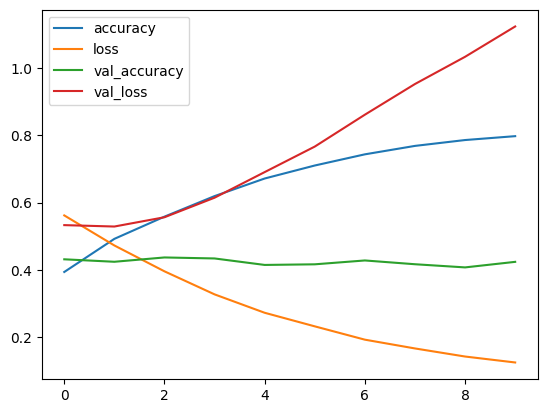

In [36]:
# plot the training and validation loss
plt.figure(figsize=(10, 6))
pd.DataFrame(history.history).plot()
plt.show()